# Data

In [1]:
from fredapi import Fred
# import plotly.graph_objects as go #used for data visualization
import pandas as pd
from statsmodels.tsa.api import VAR
from fredapi import Fred
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
 
# we can import data from fred in case we need to
fred = Fred(api_key='0e929d96cfbf2133c9a346a74670f033')

# read in data from csv
bond_data_10y = pd.DataFrame(fred.get_series('DGS10')).reset_index()

# rename columns to date and real_bond
bond_data_10y.columns = ['date', 'bond']

gold_data = pd.read_csv('gold.csv')
gold_data.columns = ['date', 'gold']

oil_data_US = pd.DataFrame(fred.get_series('DCOILWTICO')).reset_index()
oil_data_EU = pd.DataFrame(fred.get_series('DCOILBRENTEU')).reset_index()

oil_data_US.columns = ['date', 'oil']
oil_data_EU.columns = ['date', 'oil_EU']

oil_data = oil_data_US

# Convert 'date' column to datetime format for consistency
oil_data['date'] = pd.to_datetime(oil_data['date'])
gold_data['date'] = pd.to_datetime(gold_data['date'])
bond_data_10y['date'] = pd.to_datetime(bond_data_10y['date'])

# Merge datasets on the 'date' column with left merge
merged_data = pd.merge(bond_data_10y, oil_data, on='date', how='left')
merged_data = pd.merge(merged_data, gold_data, on='date', how='left')

# Forward fill missing values
merged_data = merged_data.ffill()

# drop NaN values
merged_data = merged_data.dropna()

df = merged_data

# cut off data at 2023-11-10
df = df[df['date'] < '2023-11-10']

# drop dates before 2008
df = df[df['date'] >= '2008-01-01']

# create a lagged bond column
df['bond_lag'] = df['bond'].shift(1)
df['gold_lag'] = df['gold'].shift(1)
df['oil_lag'] = df['oil'].shift(1)

df = df.dropna()

# reset index
df = df.reset_index(drop=True)

# Splitting the data into independent and dependent variables
X = df[['bond_lag', 'gold_lag', 'oil_lag']]  # independent variables
y = df['bond']  # Target variable

# Perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)

df_diff = df.diff().dropna()

# Decision Tree Regressor

In [2]:
def decision_tree_regressor(max_depth, X_train, X_test, y_train, y_test, verbose=False):

    from sklearn.tree import DecisionTreeRegressor
    from sklearn.model_selection import train_test_split

    # Create a decision tree regression model with default arguments
    decision_tree = DecisionTreeRegressor(max_depth=max_depth, random_state = 42)

    # Fit the model to the training data
    decision_tree.fit(X_train, y_train)

    # Check the score of the model on the test set
    score = decision_tree.score(X_test, y_test)

    # Model Evaluation
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    # Get the predictions from your decision tree model
    predictions = decision_tree.predict(X_test)

    # Compute Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, predictions)

    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # Compute Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

    if verbose:
        # Print out the MAE, Rrmse, and MAPE
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape}")
    
    return decision_tree, rmse

rmse_list = {}

for depth in range(1, 100):
    _, rmse = decision_tree_regressor(depth, X_train, X_test, y_train, y_test)
    
    # insert value into dictionary
    rmse_list[depth] = rmse

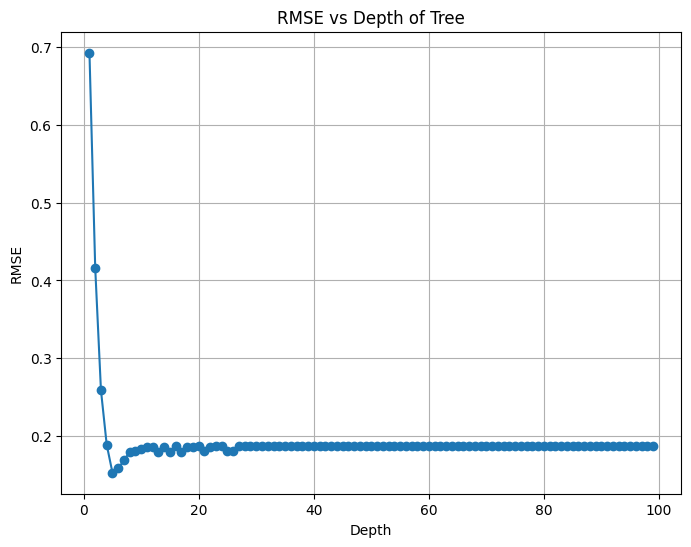

5 0.15309906258852332


In [3]:
depths = list(rmse_list.keys())
rmse_values = list(rmse_list.values())

plt.figure(figsize=(8, 6))
plt.plot(depths, rmse_values, marker='o', linestyle='-')
plt.xlabel('Depth')
plt.ylabel('RMSE')
plt.title('RMSE vs Depth of Tree')
plt.grid(True)
plt.show()

min_depth = min(rmse_list, key=rmse_list.get)
min_rmse = rmse_list[min_depth]

print(min_depth, min_rmse)

## Model Evaluation

In [4]:
decision_tree, rmse = decision_tree_regressor(min_depth, X_train, X_test, y_train, y_test, verbose=True)

Mean Absolute Error (MAE): 0.09675391591530927
Root Mean Squared Error (RMSE): 0.15309906258852332
Mean Absolute Percentage Error (MAPE): 4.524360044257289


## Model Visualization

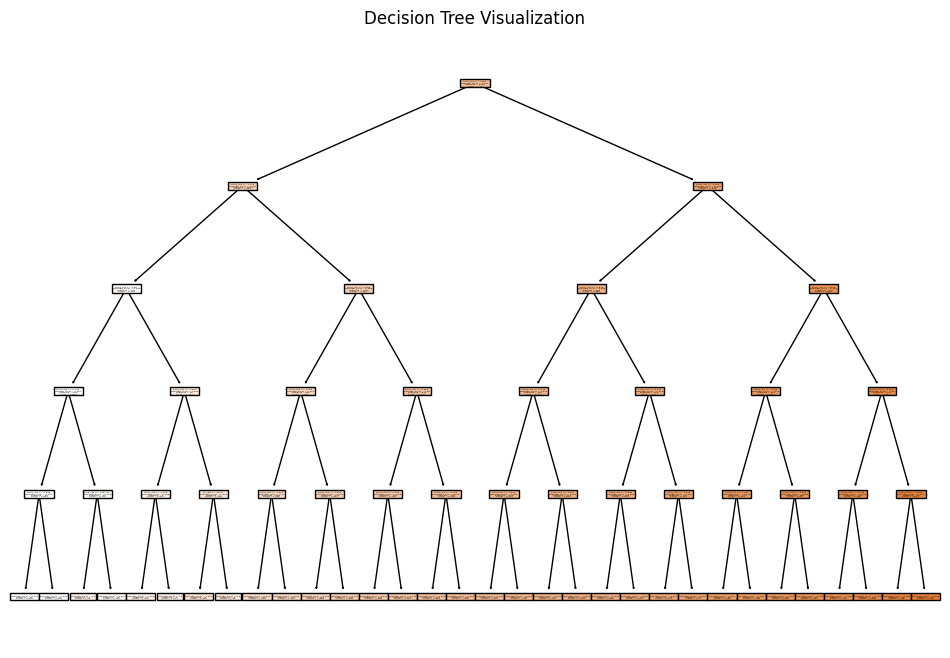

In [5]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plotting the decision tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree, feature_names=X.columns, filled=True)
plt.title("Decision Tree Visualization")
plt.show()

## Plotting

2020-09-08 00:00:00 2008-01-02 00:00:00


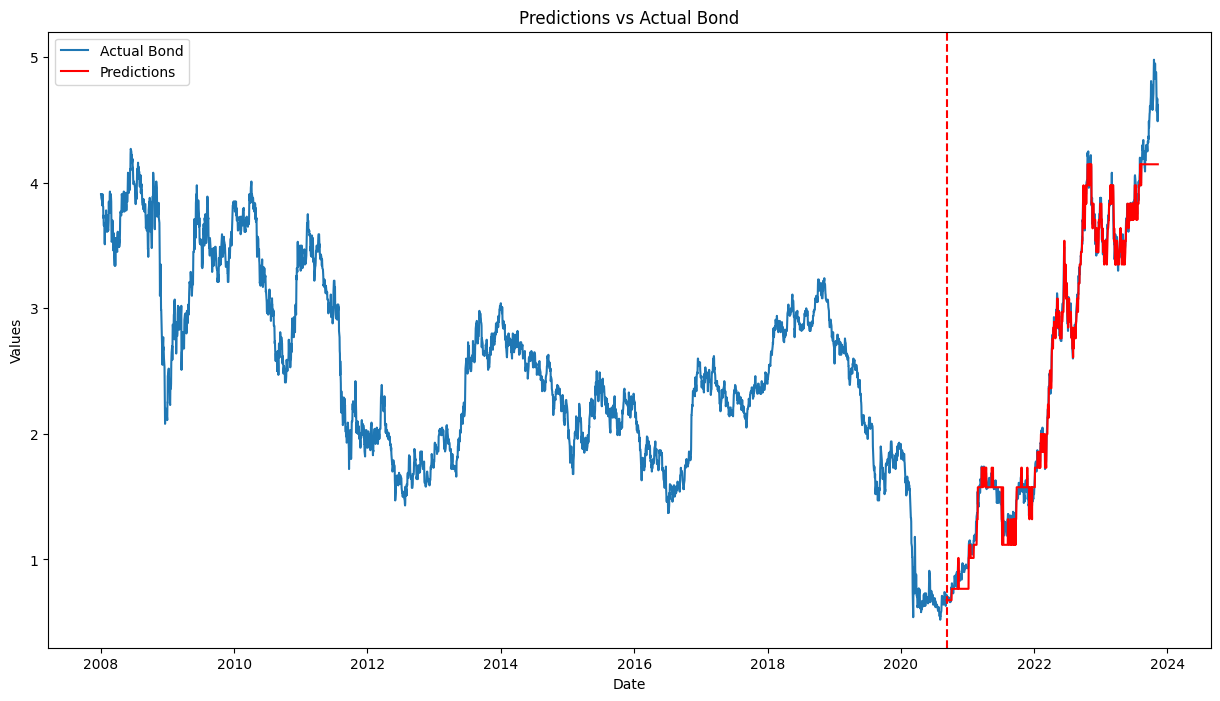

In [6]:
# get the first index of the test set
first_test_index = X_test.index[0]
first_train_index = X_train.index[0]

# get the date of first_test_index from df
first_test_date = df.loc[first_test_index, 'date']
first_train_date = df.loc[first_train_index, 'date']

print(first_test_date, first_train_date)

df_results = df.copy()

df_results['predictions'] = decision_tree.predict(X)

# Set predictions before the first test date to NaN
df_results.loc[df_results.index < first_test_index, 'predictions'] = np.nan


# Set 'date' column as the index
df_results.set_index('date', inplace=True)

plt.figure(figsize=(15, 8))
plt.plot(df_results.index, df_results['bond'], label='Actual Bond')
plt.plot(df_results.index, df_results['predictions'], label='Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Predictions vs Actual Bond')
plt.legend()

# Plot vertical line where test data begins
test_data_begin_index = 100  # Replace this with the actual index where test data begins
plt.axvline(x=first_test_date, color='red', linestyle='--', label='Test Data Begins')

plt.show()

# Random Forest Regressor

## Model

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def random_forest_regressor(max_depth, X_train, X_test, y_train, y_test, verbose=False):
    # Create a random forest regression model with default arguments
    random_forest = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=42)

    # Fit the model to the training data
    random_forest.fit(X_train, y_train)

    # Get the predictions from your random forest model
    predictions = random_forest.predict(X_test)

    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # Compute Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, predictions)

    # Compute Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

    if verbose:
        # Print out the RMSE, MAE, and MAPE
        print(f"Root Mean Squared Error (RMSE) with max_depth={max_depth}: {rmse}")
        print(f"Mean Absolute Error (MAE) with max_depth={max_depth}: {mae}")
        print(f"Mean Absolute Percentage Error (MAPE) with max_depth={max_depth}: {mape}")
    
    return random_forest, rmse, mae, mape

rmse_list = {}
mae_list = {}
mape_list = {}

for depth in range(1, 40):
    _, rmse, mae, mape = random_forest_regressor(depth, X_train, X_test, y_train, y_test, verbose=False)
    
    # Insert values into dictionaries
    rmse_list[depth] = rmse
    mae_list[depth] = mae
    mape_list[depth] = mape

## Model Evaluation

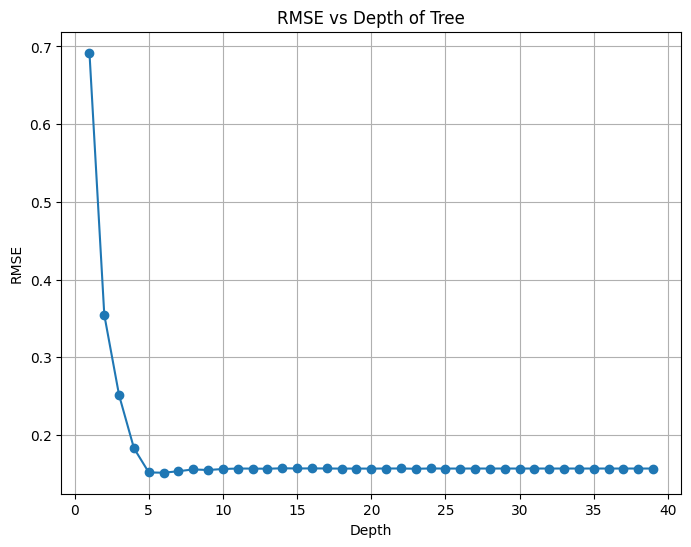

6 0.1514490436154478


In [8]:
depths = list(rmse_list.keys())
rmse_values = list(rmse_list.values())

plt.figure(figsize=(8, 6))
plt.plot(depths, rmse_values, marker='o', linestyle='-')
plt.xlabel('Depth')
plt.ylabel('RMSE')
plt.title('RMSE vs Depth of Tree')
plt.grid(True)
plt.show()

min_depth = min(rmse_list, key=rmse_list.get)
min_rmse = rmse_list[min_depth]

print(min_depth, min_rmse)

In [9]:
best_model, _, _, _, = random_forest_regressor(min_depth, X_train, X_test, y_train, y_test, verbose=True)

Root Mean Squared Error (RMSE) with max_depth=6: 0.1514490436154478
Mean Absolute Error (MAE) with max_depth=6: 0.08721611396780009
Mean Absolute Percentage Error (MAPE) with max_depth=6: 3.803140280318075


## Model Visualization

2020-09-08 00:00:00 2008-01-02 00:00:00


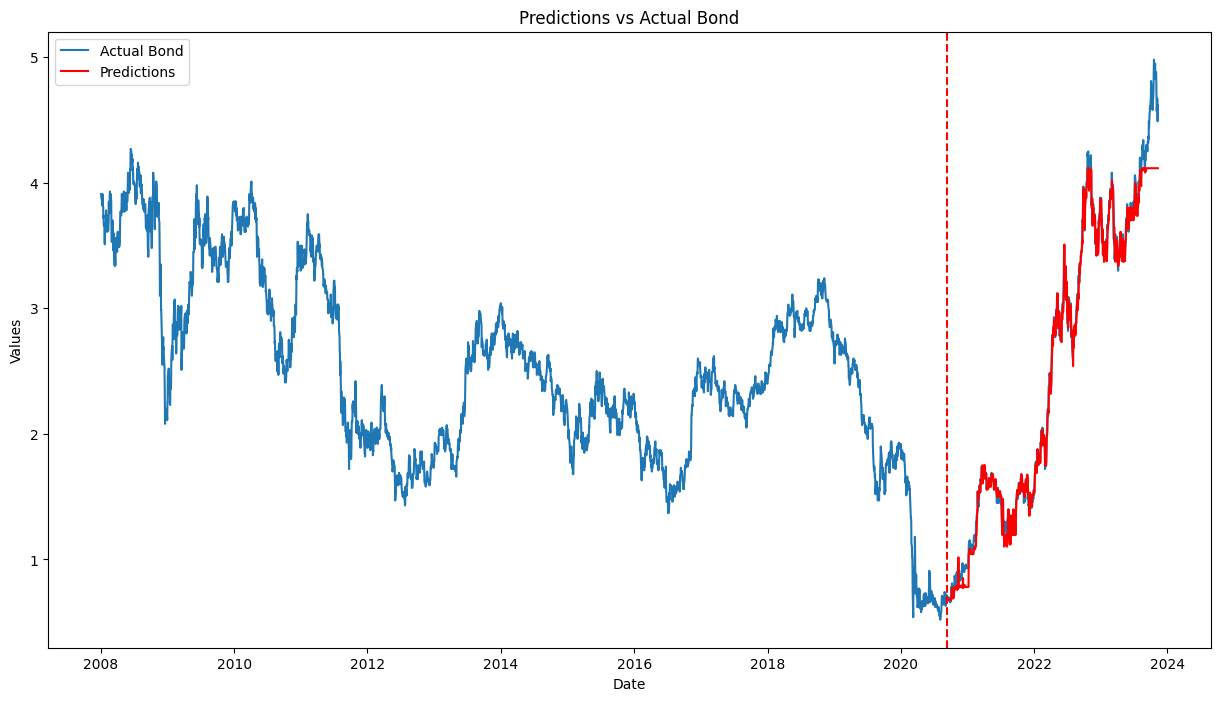

In [10]:
# get the first index of the test set
first_test_index = X_test.index[0]
first_train_index = X_train.index[0]

# get the date of first_test_index from df
first_test_date = df.loc[first_test_index, 'date']
first_train_date = df.loc[first_train_index, 'date']

print(first_test_date, first_train_date)

df_results = df.copy()

df_results['predictions'] = best_model.predict(X)

# Set predictions before the first test date to NaN
df_results.loc[df_results.index < first_test_index, 'predictions'] = np.nan

# Set 'date' column as the index
df_results.set_index('date', inplace=True)

plt.figure(figsize=(15, 8))
plt.plot(df_results.index, df_results['bond'], label='Actual Bond')
plt.plot(df_results.index, df_results['predictions'], label='Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Predictions vs Actual Bond')
plt.legend()

# Plot vertical line where test data begins
test_data_begin_index = 100  # Replace this with the actual index where test data begins
plt.axvline(x=first_test_date, color='red', linestyle='--', label='Test Data Begins')

plt.show()

# XGBoost Regressor

In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def xgboost_regressor(max_depth, X_train, X_test, y_train, y_test, verbose=False):
    # Create an XGBoost regression model with specified max_depth
    xgboost = XGBRegressor(max_depth=max_depth, random_state=42)

    # Fit the model to the training data
    xgboost.fit(X_train, y_train)

    # Get the predictions from your XGBoost model
    predictions = xgboost.predict(X_test)

    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # Compute Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, predictions)

    # Compute Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

    if verbose:
        # Print out the RMSE, MAE, and MAPE
        print(f"Root Mean Squared Error (RMSE) with max_depth={max_depth}: {rmse}")
        print(f"Mean Absolute Error (MAE) with max_depth={max_depth}: {mae}")
        print(f"Mean Absolute Percentage Error (MAPE) with max_depth={max_depth}: {mape}")
    
    return xgboost, rmse, mae, mape

rmse_list = {}
mae_list = {}
mape_list = {}

# Assuming you have X_train, X_test, y_train, and y_test defined

for depth in range(1, 40):
    _, rmse, mae, mape = xgboost_regressor(depth, X_train, X_test, y_train, y_test, verbose=False)
    
    # Insert values into dictionaries
    rmse_list[depth] = rmse
    mae_list[depth] = mae
    mape_list[depth] = mape

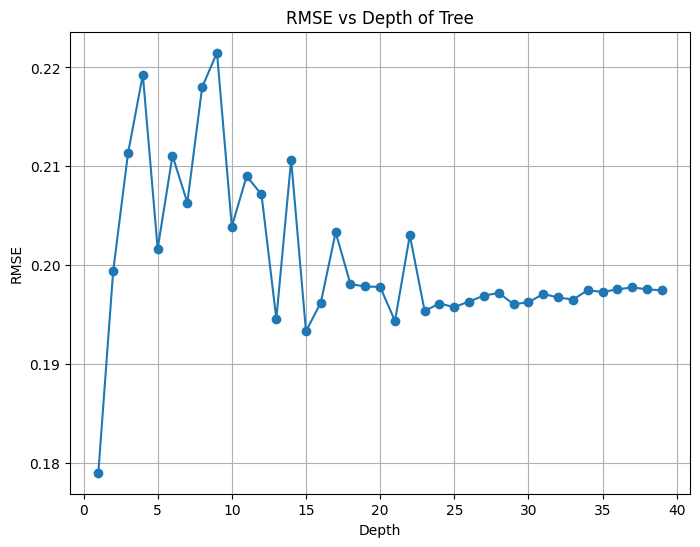

1 0.17901041978591395


In [12]:
depths = list(rmse_list.keys())
rmse_values = list(rmse_list.values())

plt.figure(figsize=(8, 6))
plt.plot(depths, rmse_values, marker='o', linestyle='-')
plt.xlabel('Depth')
plt.ylabel('RMSE')
plt.title('RMSE vs Depth of Tree')
plt.grid(True)
plt.show()

min_depth = min(rmse_list, key=rmse_list.get)
min_rmse = rmse_list[min_depth]

print(min_depth, min_rmse)

In [13]:
best_model, _, _, _, = xgboost_regressor(min_depth, X_train, X_test, y_train, y_test, verbose=True)

Root Mean Squared Error (RMSE) with max_depth=1: 0.17901041978591395
Mean Absolute Error (MAE) with max_depth=1: 0.10743573186478177
Mean Absolute Percentage Error (MAPE) with max_depth=1: 4.716643177007093


## Model Visualization

In [14]:
# get the first index of the test set
first_test_index = X_test.index[0]
first_train_index = X_train.index[0]

# get the date of first_test_index from df
first_test_date = df.loc[first_test_index, 'date']
first_train_date = df.loc[first_train_index, 'date']

print(first_test_date, first_train_date)

df_results = df.copy()

df_results['predictions'] = best_model.predict(X)

# Set predictions before the first test date to NaN
df_results.loc[df_results.index < first_test_index, 'predictions'] = np.nan

# Set 'date' column as the index
df_results.set_index('date', inplace=True)

2020-09-08 00:00:00 2008-01-02 00:00:00


In [15]:
import plotly.graph_objects as go #used for data visualization

# Original Plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_results.index, y=df_results['bond'],  name='Actual Bond'))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results['predictions'], name='Predictions', line=dict(color='red')))
fig.add_trace(go.Scatter(x=[first_test_date, first_test_date], y=[0, 6], name='Test Data Begins', line=dict(color='black', dash='dash')))
fig.update_layout(title='Predictions vs Actual Bond', xaxis_title='Date', yaxis_title='Values')
fig.show()

In [16]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def time_series_cv_xgboost(X, y, n_splits=5, max_depth=3, random_state=42):
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    rmse_list = []
    mae_list = []
    mape_list = []

    # Iterate through TimeSeriesSplit splits
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create an XGBoost regression model
        xgboost = XGBRegressor(max_depth=max_depth, random_state=random_state)

        # Fit the model to the training data
        xgboost.fit(X_train, y_train)

        # Get the predictions from the XGBoost model
        predictions = xgboost.predict(X_test)

        # Compute evaluation metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

        # Append metrics to lists
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)

    # Calculate average metrics across folds
    avg_rmse = np.mean(rmse_list)
    avg_mae = np.mean(mae_list)
    avg_mape = np.mean(mape_list)

    return avg_rmse, avg_mae, avg_mape, xgboost

# Example usage:
# avg_rmse, avg_mae, avg_mape = time_series_cv_xgboost(X, y, n_splits=5, max_depth=3, random_state=42)
# print(f"Average RMSE across folds: {avg_rmse}")
# print(f"Average MAE across folds: {avg_mae}")
# print(f"Average MAPE across folds: {avg_mape}")

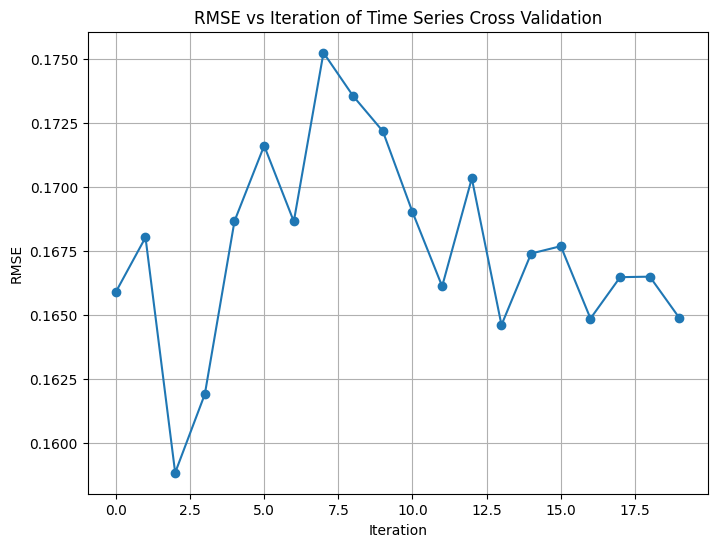

In [17]:
list_of_avg_rmse = []

for i in range(20):
    avg_rmse, avg_mae, avg_mape, _, = time_series_cv_xgboost(X, y, n_splits=10, max_depth=i, random_state=42)
    
    list_of_avg_rmse.append(avg_rmse)
    

# plot the list of avg_rmse values from the time series cross validation
plt.figure(figsize=(8, 6))
plt.plot(list_of_avg_rmse, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE vs Iteration of Time Series Cross Validation')
plt.grid(True)
plt.show()

<Axes: title={'center': 'Bond vs Predictions'}, xlabel='date'>

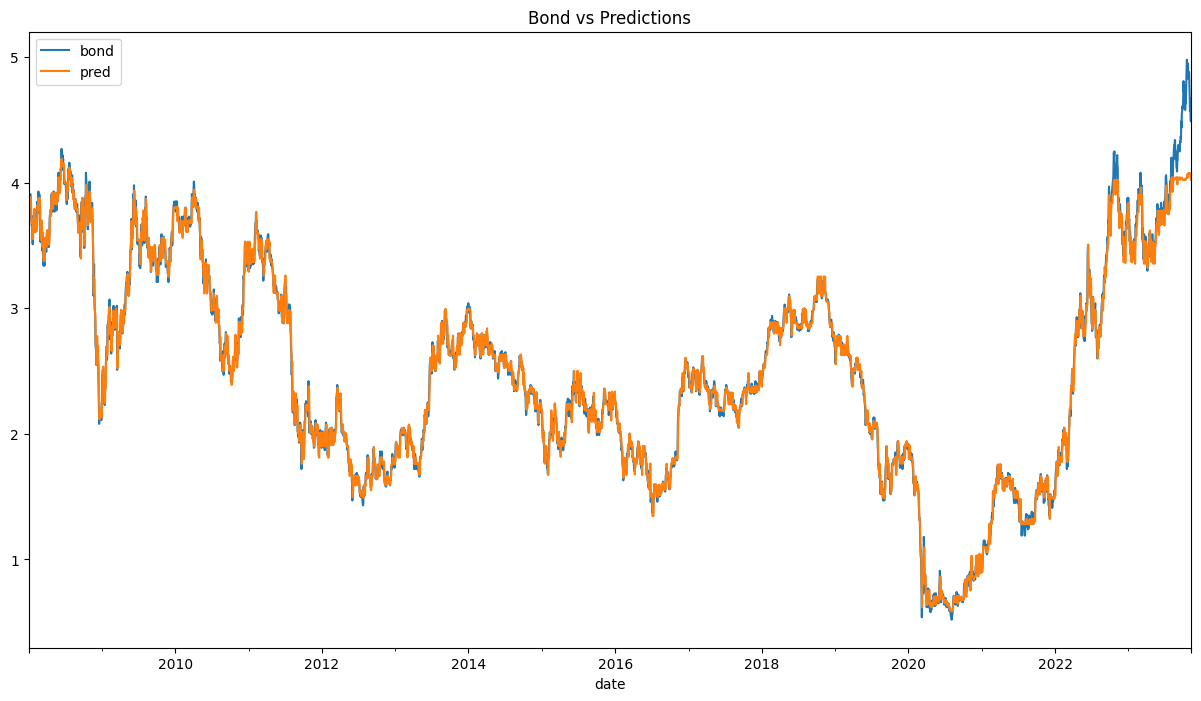

In [18]:
# get the index of the minimum avg_rmse
min_index = list_of_avg_rmse.index(min(list_of_avg_rmse))

results =  time_series_cv_xgboost(X, y, n_splits=10, max_depth=min_index, random_state=42)

model = results[len(results) - 1]

dff = df.copy()

dff['pred'] = model.predict(X)

dff[['date','bond', 'pred']].plot(x='date', figsize=(15, 8), title='Bond vs Predictions')